1エポック目
  平均クロスエントロピー誤差: 0.9820017761812432
  テストデータに対する正答率: 0.8798
  学習データに対する正答率: 0.8721333333333333
2エポック目
  平均クロスエントロピー誤差: 0.49004506876972537
  テストデータに対する正答率: 0.9013
  学習データに対する正答率: 0.8971666666666667
3エポック目
  平均クロスエントロピー誤差: 0.3880036685512028
  テストデータに対する正答率: 0.9111
  学習データに対する正答率: 0.9117333333333333
4エポック目
  平均クロスエントロピー誤差: 0.33841415268011055
  テストデータに対する正答率: 0.92
  学習データに対する正答率: 0.91905
5エポック目
  平均クロスエントロピー誤差: 0.30756567438607635
  テストデータに対する正答率: 0.9252
  学習データに対する正答率: 0.9231333333333334


/tmp/ipykernel_1352/185281977.py:77: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


6エポック目
  平均クロスエントロピー誤差: 0.2861074594128979
  テストデータに対する正答率: 0.9259
  学習データに対する正答率: 0.9271833333333334
7エポック目
  平均クロスエントロピー誤差: 0.2682024755142802
  テストデータに対する正答率: 0.9315
  学習データに対する正答率: 0.93135
8エポック目
  平均クロスエントロピー誤差: 0.25304115710025216
  テストデータに対する正答率: 0.9322
  学習データに対する正答率: 0.9345333333333333
9エポック目
  平均クロスエントロピー誤差: 0.24200865779895367
  テストデータに対する正答率: 0.9335
  学習データに対する正答率: 0.9366666666666666
10エポック目
  平均クロスエントロピー誤差: 0.23127891863412903
  テストデータに対する正答率: 0.9359
  学習データに対する正答率: 0.9400166666666666


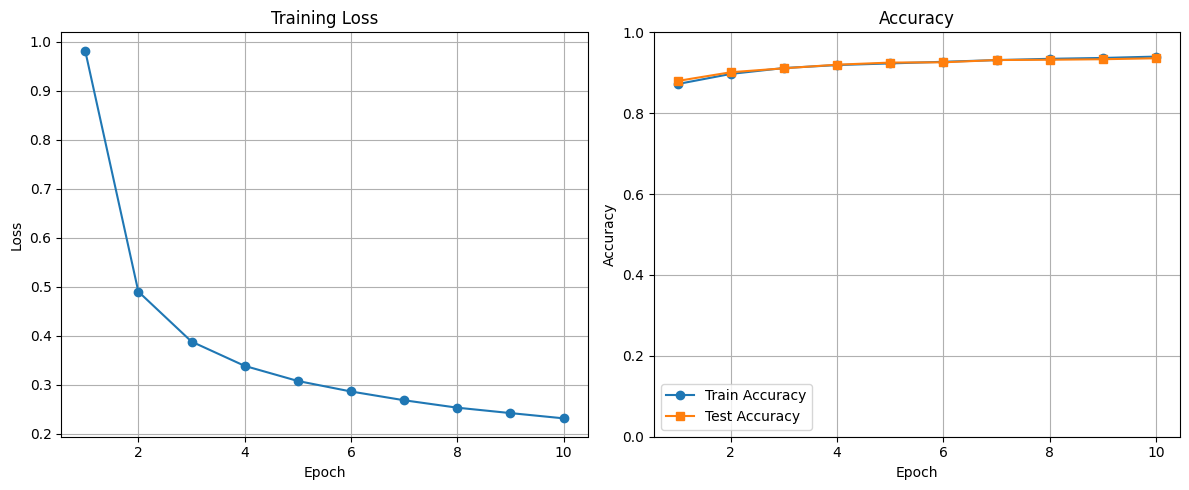

In [5]:
import numpy as np 
import mnist 
import matplotlib.pyplot as plt
# import sys

# データの読み込み
train_images = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/train-images-idx3-ubyte.gz")
train_labels = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/train-labels-idx1-ubyte.gz")
test_images = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/t10k-images-idx3-ubyte.gz")
test_labels = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/t10k-labels-idx1-ubyte.gz")

# # --- ユーザー入力と前処理 ---
# def get_input_image_vector():
#     # ユーザーから画像番号を入力させ、対応する画像ベクトルを返す
#     try:
#         image_number = int(input("0~9999までの整数を入力してください："))
#         if not (0 <= image_number <= 9999):
#             print("無効な数値です。")
#             sys.exit()
 
#         # 28x28の画像を1次元ベクトルに変換
#         return train_images[image_number].reshape(-1)
#     except ValueError:
#         print("無効な入力です。整数を入力してください。")
#         sys.exit()

# def get_random_index(batch_size): #インデックスをランダムに取得
#     # np.arangeの生成を省略し、直接データ数からサンプリングする
#     return np.random.choice(len(train_images), size=batch_size, replace=False)

def get_shaffled_index():
    index = np.arange(len(train_images)) # 0から始まるインデックスの配列を作成
    np.random.shuffle(index) # インデックスをシャッフル
    return index

# 画像とラベルを別々に取得する冗長な関数を一つに統合
def get_batch(random_index): 
    # ベクトルとラベルをまとめて取得
    batch_images = train_images[random_index].reshape(len(random_index), -1) # 画像データを (バッチサイズ, 784) の2次元配列に変換
    batch_labels = train_labels[random_index]
    return batch_images, batch_labels

def get_one_hot_label(batch_labels, output_layer_size):
    one_hot_labels = np.zeros((batch_labels.size, output_layer_size)) # ゼロで満たされた配列を作成
    one_hot_labels[np.arange(batch_labels.size), batch_labels] = 1 # 各行の、正解ラベルに対応するインデックスを1にする
    return one_hot_labels


np.random.seed(777) # シードを固定

# レイヤーの次元数を定義
input_size = train_images[0].size  # 入力層: 784 (28*28)
hidden_layer_size = 100 # 中間層: 100ユニット
output_layer_size = 10  # 出力層: 10ユニット (0-9の数字に対応)

# 重みとバイアスを正規分布で初期化

is_load = str(input('ロードしますか？ yes or no:  '))
if is_load == 'yes' :
    loaded_data = np.load('assignment3_parameter.npz')
    weight1 = loaded_data['weight1']
    bias1 = loaded_data['bias1']
    weight2 = loaded_data['weight2']
    bias2 = loaded_data['bias2']
else:
    # 第1層（入力層 -> 中間層）
    weight1 = np.random.normal(loc=0.0, scale=np.sqrt(1 / input_size), size=(hidden_layer_size, input_size)) # weight1: (100, 784) 784個の入力それぞれに対する、100個の隠れ層ユニットの重み
    bias1 = np.random.normal(loc=0.0, scale=np.sqrt(1 / input_size), size=hidden_layer_size) # bias1: (100,) 100個の隠れ層ユニットのバイアス

    # 第2層（中間層 -> 出力層）
    weight2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=(output_layer_size, hidden_layer_size)) # weight2: (10, 100) 100個の隠れ層ユニットそれぞれに対する、10個の出力層ユニットの重み
    bias2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=output_layer_size) # bias2: (10,) 10個の出力層ユニットのバイアス

# --- 活性化関数と出力関数 ---
def sigmoid(x):
    """シグモイド活性化関数"""
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """
    ソフトマックス関数（オーバーフロー対策版）
    各要素を0から1の間の確率に変換
    """
    alpha = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - alpha)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# --- 順伝播の実行(重みを更新) ---
def forward_propagation(input_vector, weight1, bias1, weight2, bias2):
    
    # 中間層の計算: 活性化関数の入力　 (バッチサイズ, 784) @ (784, 100) -> (バッチサイズ, 100)
    hidden_layer_input = np.dot(input_vector, weight1.T) + bias1
    
    # 中間層の出力: 活性化関数を適用
    hidden_layer_output = sigmoid(hidden_layer_input)
    
    # 出力層の計算: 活性化関数の入力　(バッチサイズ, 100) @ (100, 10) -> (バッチサイズ, 10)
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    
    # 出力層の出力: ソフトマックスを適用して確率を算出
    final_output = softmax(output_layer_input)
    
    return final_output, hidden_layer_output # hidden 追加

def get_predicted_class(output_probabilities):
 # 出力された確率から最も高い確率を持つクラス（予測結果）を取得
    if output_probabilities.ndim == 1:
        return np.argmax(output_probabilities)
    else:
        return np.argmax(output_probabilities, axis=1)

def get_cross_entropy_error(y_pred, y_true):
    
    delta = 1e-7
    
    loss = -np.sum(y_true * np.log(y_pred + delta)) # logの中身が0にならないようにdeltaを導入
    
    # ミニバッチサイズBで割って平均を求める
    batch_size = y_pred.shape[0]
    
    cross_entropy_error = loss / batch_size
    
    return cross_entropy_error

def backward_propagation_and_update(batch_image_vector, hidden_layer_output, output_probabilities, one_hot_labels, 
                                    weight1, bias1, weight2, bias2, learning_rate):
    """
    逆伝播法を用いて勾配を計算し、全パラメータを更新する関数。
    更新後のパラメータを返す。
    """
    current_batch_size = batch_image_vector.shape[0]
    
    # --- 逆伝播 ---
    dEn_dak = (output_probabilities - one_hot_labels) / current_batch_size
    dEn_dX = np.dot(dEn_dak, weight2)
    dEn_dW_1 = np.dot(dEn_dak.T, hidden_layer_output)
    dEn_db_1 = np.sum(dEn_dak, axis = 0)
    dEn_dX_sig = dEn_dX * (hidden_layer_output * (1 - hidden_layer_output))
    dEn_dW_2= np.dot(dEn_dX_sig.T, batch_image_vector)
    dEn_db_2 = np.sum(dEn_dX_sig, axis=0)

    # --- パラメータ更新 ---
    weight1 -= dEn_dW_2 * learning_rate 
    bias1   -= dEn_db_2 * learning_rate
    weight2 -= dEn_dW_1 * learning_rate 
    bias2   -= dEn_db_1 * learning_rate
    
    return weight1, bias1, weight2, bias2

def get_accuracy(y_prop, y_true): # 正答率計算
    y_pred = get_predicted_class(y_prop) # 予測結果
    accuracy = np.sum(y_pred == y_true) / len(y_prop)
    return accuracy

def calculate_accuracy(images, labels, weight1, bias1, weight2, bias2):
    """
    指定されたデータセットに対するモデルの正答率を計算する関数。
    """
    # 1. データ全体を (枚数, 784) のベクトルに変換
    images_vector = images.reshape(len(images), -1)
    
    # 2. 順伝播で予測確率を計算
    probabilities, _ = forward_propagation(images_vector, weight1, bias1, weight2, bias2)
    
    # 3. 正答率を計算
    accuracy = get_accuracy(probabilities, labels)
    
    return accuracy

# --- メイン処理 ---
if __name__ == "__main__":

    batch_size = 100
    epoch_number = 10
    learning_rate = 0.01
    train_loss_list, train_acc_list, test_acc_list = [], [], []
    
    for i in range(1, epoch_number + 1):
        error_sum = 0
        shaffled_index = get_shaffled_index()
        
        for j in range(0, len(shaffled_index), batch_size): # range(start, stop, step) を使い、batch_sizeずつインデックスをずらしながらループ
            
            #シャッフルしたインデックスから、先頭のbatch_size分取り出す
            index = shaffled_index[j:j + batch_size]

            # 統合した関数を使い、ミニバッチと対応ラベルを一度に取得
            batch_image_vector, batch_labels = get_batch(index)

            # 順伝播を実行
            output_probabilities, hidden_layer_output = forward_propagation(
                batch_image_vector, weight1, bias1, weight2, bias2
            )
            # one-hot labelsを取得
            one_hot_labels = get_one_hot_label(batch_labels, output_layer_size)

            
            # クロスエントロピー誤差平均を計算
            calculated_error = get_cross_entropy_error(output_probabilities, one_hot_labels)
            error_sum += calculated_error
            
            # --- 逆伝播 ---
            weight1, bias1, weight2, bias2 = backward_propagation_and_update(
                batch_image_vector, hidden_layer_output, output_probabilities, one_hot_labels,
                weight1, bias1, weight2, bias2, learning_rate
            )

        train_accuracy = calculate_accuracy(train_images, train_labels, weight1, bias1, weight2, bias2)
        test_accuracy = calculate_accuracy(test_images, test_labels, weight1, bias1, weight2, bias2)
        
        num_batches = len(train_images) // batch_size
        train_loss_list.append(error_sum / num_batches)
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        print(f"{i}エポック目")
        print(f"  平均クロスエントロピー誤差: {error_sum / num_batches}")
        print(f"  テストデータに対する正答率: {test_accuracy}") 
        print(f"  学習データに対する正答率: {train_accuracy}")
        
    # --- グラフの描画 ---
    x = np.arange(1, epoch_number + 1)
    plt.figure(figsize=(12, 5))

    # 誤差のグラフ
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss_list, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # 正答率のグラフ
    plt.subplot(1, 2, 2)
    plt.plot(x, train_acc_list, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc_list, marker='s', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    np.savez('assignment3_parameter.npz', weight1 = weight1, bias1 = bias1, weight2 = weight2, bias2 = bias2)